# MILESTONE 2 PHASE 2
`Kevin Boy Gunawan`
<br>

`FTDS-009`

## 1. Introduction

**Background**

LEGO is one of the bestselling toy brands for its iconic bricks that allow children and adults to explore their creativity. for many years, lego have already released thousand of set ranging from superhero theme to the advance one, lego technic. 

For this numerous count of set, there are must be 10 to 100 unique brick for each set and each of unique brick named by unique ID. each unique part on lego is called element and there are at least 3,700+ different LEGO elements (this includes all LEGO bricks and other LEGO elements).

**Objective**

Objective that i want to achieve in this project is making a simple lego part classifier using Convolutional Neural Network.

**About Datasets**

Dataset used in this project was uploaded by RONAN PICKELL on kaggle.com. the dataset contained 4000 images for each 200 unique lego part, so at least there are 800.000 images in total contained on dataset.

link : https://www.kaggle.com/datasets/ronanpickell/b200c-lego-classification-dataset

**Limitation**

before dig in further into main section of this project, i need to make disclaimer that the lego part im going to classify in this project are limited to 20 lego parts only.

## 2. Import Libraries

In [ ]:
import os
import random as rn
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

## 3. Data Loading

### Get Data

In [ ]:
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle
 
!mkdir ./kaggle 
!mv ./kaggle.json ./kaggle 

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json 
!ls ~/.kaggle 

kaggle.json


In [ ]:
!kaggle datasets download -d ronanpickell/b200c-lego-classification-dataset

100% 1.11G/1.11G [00:43<00:00, 45.6MB/s]
100% 1.11G/1.11G [00:43<00:00, 27.4MB/s]


In [ ]:
!unzip -q /content/b200c-lego-classification-dataset.zip -d images

### Get Dataframe

as i stated in my objective and limitation, in this case im going to classify 20 lego parts only.

In [ ]:
target = sorted(os.listdir('/content/images/64'))[0:20]

In [ ]:
main_path= ['/content/images/64/']

for each lego parts or classes im going to pick 2000 images.

In [ ]:
data = []
label = []
for i in target:
  for j in range(2000):
    a = main_path[0] + i + '/' + os.listdir('/content/images/64/'+i)[j]
    b = i
    data.append(a)
    label.append(b)

In [ ]:
df = pd.DataFrame({'image': data, 'label': label}).sample(frac=1, random_state=0).reset_index(drop=True)

In [ ]:
df.head()

image  label
0  /content/images/64/11476/1454.jpg  11476
1  /content/images/64/11458/2625.jpg  11458
2  /content/images/64/11211/1034.jpg  11211
3  /content/images/64/11214/3239.jpg  11214
4  /content/images/64/15392/1072.jpg  15392

so this is lego Number parts that im going to classify

In [ ]:
#lego part
df['label'].unique()

array(['11476', '11458', '11211', '11214', '15392', '15100', '15379',
       '18651', '11212', '15573', '11477', '15712', '14704', '11090',
       '14719', '15070', '14769', '15068', '10247', '15535'], dtype=object)

In [ ]:
df.shape

(40000, 2)

we have 40000 images and 20 different class in total, so atleast there are 2000 images for each class

## 4. Exploratory Data Analysis (EDA)

In [ ]:
def im_plot(data, part, jum):
  datas = data
  for i in part:
    a = datas[datas['label']==i].sample(jum, random_state=5)
    fig, ax = plt.subplots(1,jum, figsize=(15,2))
    fig.suptitle(i, size=16)
    for j in range(jum):
      img = cv2.imread(a['image'].iloc[j])
      ax[j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      ax[j].axis('off')

lets take a look images sample for each lego part

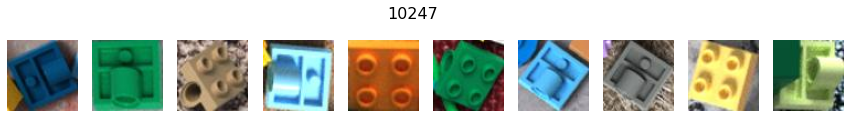

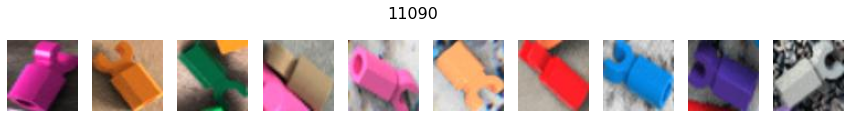

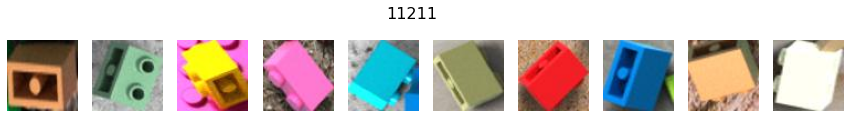

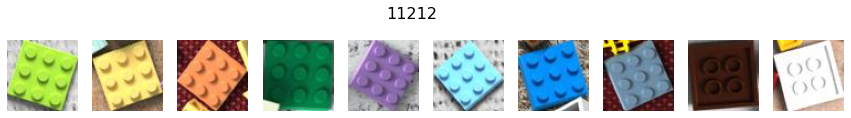

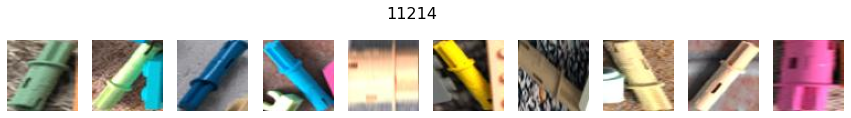

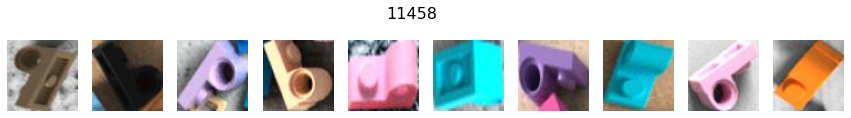

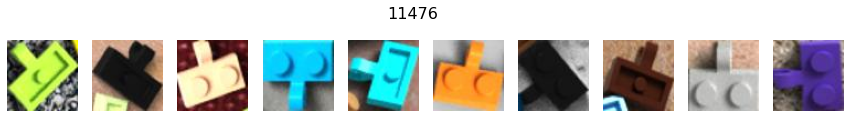

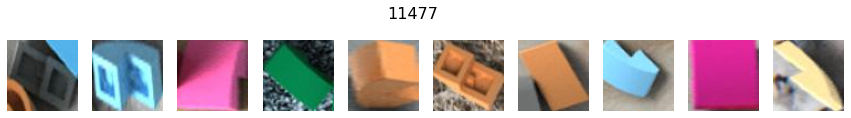

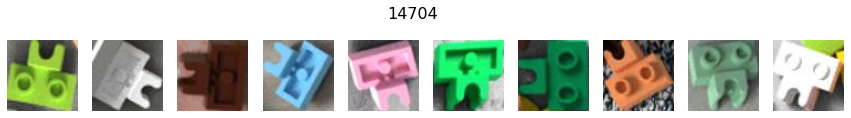

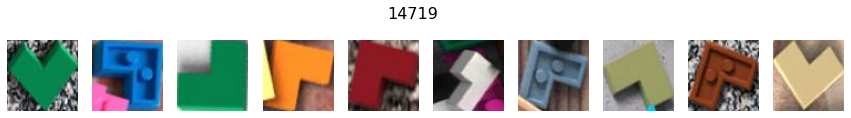

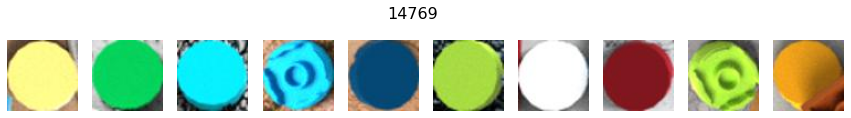

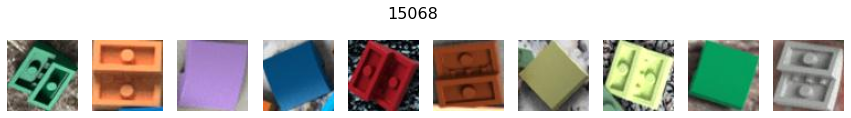

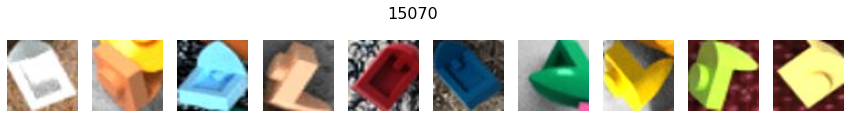

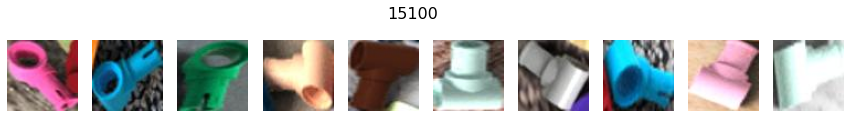

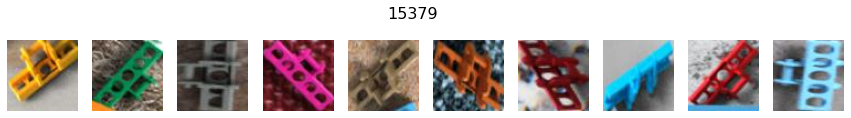

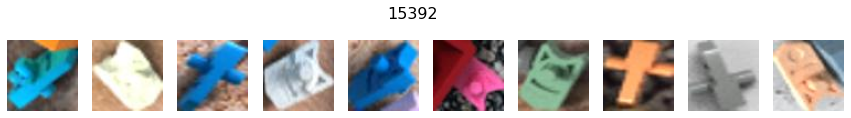

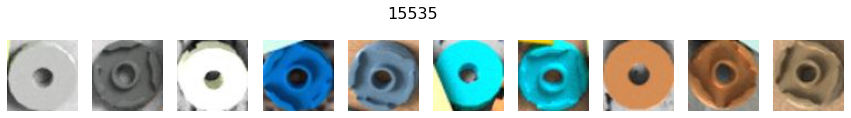

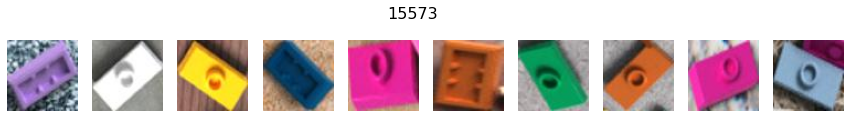

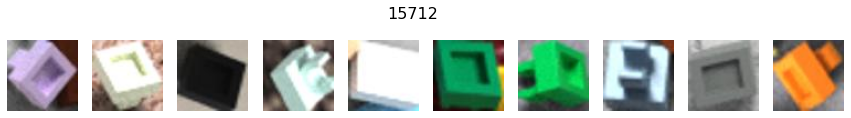

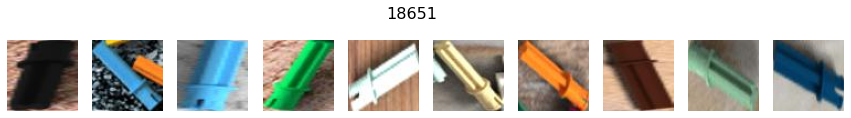

In [ ]:
im_plot(df, target, 10)

at the first glance the first thing that i notice is the variance of lego's color is really diverse, its really colorful and there is no lego model that having one specific color.

then there are some part which share the same shape. for the example, lego 11214 and lego 18651. both really have identical shape, they are long and tube-like shaped. 

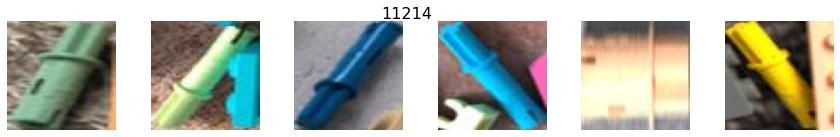

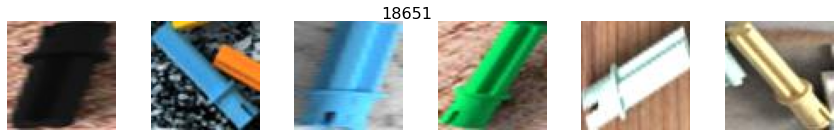

In [ ]:
im_plot(df, ['11214', '18651'], 6)


another example we have lego 14769 and 15535. they both also share the same circle shape, but the only difference is some part has hole on it and the other part don't.

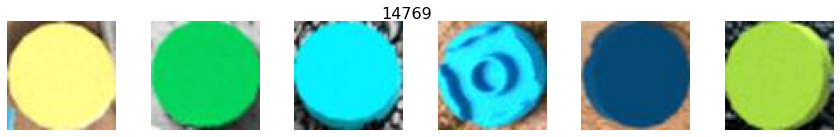

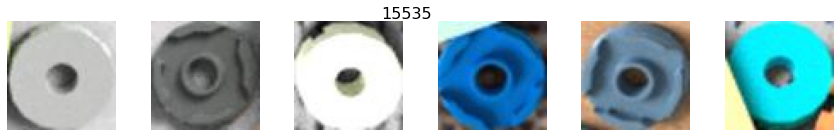

In [ ]:
im_plot(df, ['14769', '15535'], 6)

the challenging part about this two lego model for our incoming CNN is some of this lego orientation may easily to distinguish, but at the certain angle or orientation its super hard to capture differences between them.

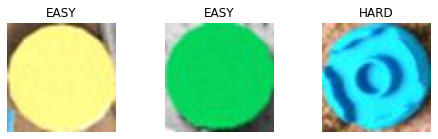

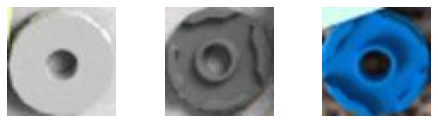

In [ ]:
lvl = ['EASY', 'EASY', 'HARD']
for l,i in enumerate(['14769', '15535']):
  a = df[df['label']==i].sample(5, random_state=5)
  fig, ax = plt.subplots(1,3, figsize=(8,2))
  for j,k in enumerate([0,1,3]):
    img = cv2.imread(a['image'].iloc[k])
    ax[j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[j].axis('off')
    if l==0:
      ax[j].set_title(lvl[j])

## 5. Data Preprocessing

all the image are originally 64x64 in size, but lets resize them again for double treatment and cross check.

In [ ]:
img_height= 64
img_width= 64
SEED = 1
BATCH = 64

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.25, random_state=0)
print(train_df.shape)
print(val_df.shape)

(30000, 2)
(10000, 2)


to make our model more 'familiar' about the image, lets do image augmentation on our training images. augmentation that i did in this part are, rotation, horizontal and vertical flip.

In [ ]:
train_generator = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=True)

val_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data = train_generator.flow_from_dataframe(dataframe=train_df,
                                               x_col='image',
                                               y_col='label',
                                               target_size=(img_height, img_width),
                                               class_mode='categorical',
                                               batch_size=BATCH,
                                               shuffle=False,
                                               seed=SEED)

Found 30000 validated image filenames belonging to 20 classes.


In [ ]:
val_data = val_generator.flow_from_dataframe(dataframe=val_df,
                                               x_col='image',
                                               y_col='label',
                                               target_size=(img_height, img_width),
                                               class_mode='categorical',
                                               batch_size=BATCH,
                                               shuffle=False,
                                               seed=SEED)

Found 10000 validated image filenames belonging to 20 classes.


i stated the number of batch is 64 and we have 30.000 images for training. its mean that for each epoch there are at least 469 images that are being trained

In [ ]:
len(train_data.classes)

30000

## 6. Model Definition

In [ ]:
inputs= [img_height,img_width,3]

this is the first and base model architecture that im going to use. i will train this model first then evaluate it to make improvement  later.

In [ ]:
model= Sequential()

model.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= inputs))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Conv2D(filters=32, kernel_size=3, activation= 'relu', input_shape= inputs))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Conv2D(filters=64, kernel_size=3, activation= 'relu', input_shape= inputs))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Flatten())
model.add(Dense(units= 64, activation='relu'))
model.add(Dense(units=20, activation='softmax'))

#compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics= ['accuracy'])

## 7. Model Training

In [ ]:
# this is function to plot evaluation visual
def evaluation(x):
  metrics = pd.DataFrame(x.history)
  fig, axes = plt.subplots(1,2, figsize=(15,5))
  metrics[['loss', 'val_loss']].plot(ax=axes[0])
  metrics[['accuracy', 'val_accuracy']].plot(ax=axes[1])

### 1st Model

lets train our first model. in this section and for upcoming section im using earlystopping with patience 3,its mean that our train will automaticlly stop if our model fail to reduce the val_loss three times relative to the current best val_loss

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3), 
    ModelCheckpoint('model.hdf5', monitor='val_loss', save_best_only=True)
    ]

history = model.fit(train_data, 
                   batch_size = BATCH,
                   epochs=100, 
                   validation_data=val_data,
                   callbacks=callbacks)

Epoch 1/100
469/469 [==============================] - 75s 140ms/step - loss: 2.3285 - accuracy: 0.2746 - val_loss: 1.8051 - val_accuracy: 0.4242
Epoch 2/100
469/469 [==============================] - 43s 91ms/step - loss: 1.5958 - accuracy: 0.5019 - val_loss: 1.4474 - val_accuracy: 0.5448
Epoch 3/100
469/469 [==============================] - 43s 91ms/step - loss: 1.3394 - accuracy: 0.5825 - val_loss: 1.2572 - val_accuracy: 0.6100
Epoch 4/100
469/469 [==============================] - 42s 90ms/step - loss: 1.1715 - accuracy: 0.6393 - val_loss: 1.1798 - val_accuracy: 0.6341
Epoch 5/100
469/469 [==============================] - 42s 90ms/step - loss: 1.0437 - accuracy: 0.6753 - val_loss: 1.0855 - val_accuracy: 0.6622
Epoch 6/100
469/469 [==============================] - 42s 90ms/step - loss: 0.9543 - accuracy: 0.7079 - val_loss: 1.1658 - val_accuracy: 0.6444
Epoch 7/100
469/469 [==============================] - 44s 94ms/step - loss: 0.8732 - accuracy: 0.7330 - val_loss: 0.9542 - val_a

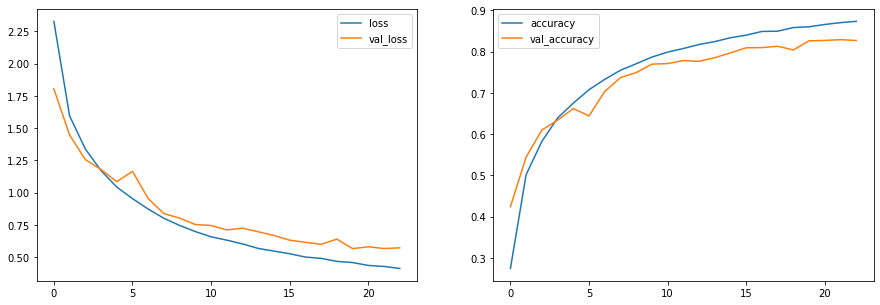

In [ ]:
evaluation(history)

looks like our first model is kinda overfit a little but it seems that on the next epoch the validation loss will gradualy decrease but not that much, so i assume that on the next epoch the val accuracy might be increasing but not that much. 

### 2nd Model

the 1st model architecture resulting a little overfit. so next im not going to play with the dense layer, lets assume the dense layer just right and dont need a tweak, so lets just focus on the convolutional layer. lets add the number of filter on convloution layer so our model can trace the picture more deeply and detailed. lets see what our model can do.

In [ ]:
model2 = Sequential()

model2.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= inputs))
model2.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= inputs))
model2.add(MaxPooling2D(pool_size=2, strides=2))

model2.add(Conv2D(filters=32, kernel_size=3, activation= 'relu', input_shape= inputs))
model2.add(Conv2D(filters=32, kernel_size=3, activation= 'relu', input_shape= inputs))
model2.add(MaxPooling2D(pool_size=2, strides=2))

model2.add(Conv2D(filters=64, kernel_size=3, activation= 'relu', input_shape= inputs))
model2.add(Conv2D(filters=64, kernel_size=3, activation= 'relu', input_shape= inputs))
model2.add(MaxPooling2D(pool_size=2, strides=2))

model2.add(Flatten())
model2.add(Dense(units= 64, activation='relu'))
model2.add(Dense(units=20, activation='softmax'))

#compile
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
callbacks2 = [EarlyStopping(monitor = 'val_loss', patience = 3), 
    ModelCheckpoint('model2.hdf5', monitor='val_loss', save_best_only=True)
    ]

history2 = model2.fit(train_data, 
                   batch_size = BATCH,
                   epochs=100, 
                   validation_data=val_data,
                   callbacks=callbacks2)

Epoch 1/100
469/469 [==============================] - 46s 97ms/step - loss: 2.3789 - accuracy: 0.2638 - val_loss: 1.8499 - val_accuracy: 0.4214
Epoch 2/100
469/469 [==============================] - 45s 95ms/step - loss: 1.5806 - accuracy: 0.5070 - val_loss: 1.3881 - val_accuracy: 0.5680
Epoch 3/100
469/469 [==============================] - 43s 92ms/step - loss: 1.2429 - accuracy: 0.6119 - val_loss: 1.1616 - val_accuracy: 0.6421
Epoch 4/100
469/469 [==============================] - 43s 92ms/step - loss: 1.0275 - accuracy: 0.6819 - val_loss: 1.0174 - val_accuracy: 0.6885
Epoch 5/100
469/469 [==============================] - 46s 98ms/step - loss: 0.8908 - accuracy: 0.7277 - val_loss: 0.8773 - val_accuracy: 0.7278
Epoch 6/100
469/469 [==============================] - 44s 93ms/step - loss: 0.7948 - accuracy: 0.7577 - val_loss: 0.7683 - val_accuracy: 0.7672
Epoch 7/100
469/469 [==============================] - 43s 93ms/step - loss: 0.7217 - accuracy: 0.7794 - val_loss: 0.7347 - val_ac

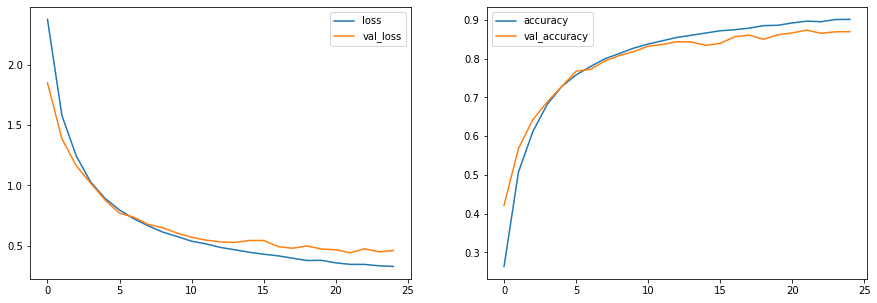

In [ ]:
evaluation(history2)

yay our model is improving now, i think we are in right track. is not that overfit unlike our very first model. but we need more than this. 

look closer to the loss and accuracy plot above, we can easily predict in the next 25 epoch the model definetly going to overfit, we know that since the train loss keep decreasing. we know that overfit means many things, but one thing that i can proposed is, our model kind of little powerful here so we need to tweak again.

### 3rd Model

so the 2nd model implies that our model a little powerful. to overcome this lets add drop out to prevent our model for being powerful.

In [ ]:
model3 = Sequential()

model3.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= inputs))
model3.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= inputs))
model3.add(MaxPooling2D(pool_size=2, strides=2))

model3.add(Conv2D(filters=32, kernel_size=3, activation= 'relu', input_shape= inputs))
model3.add(Conv2D(filters=32, kernel_size=3, activation= 'relu', input_shape= inputs))
model3.add(MaxPooling2D(pool_size=2, strides=2))
model3.add(Dropout(0.2))

model3.add(Conv2D(filters=64, kernel_size=3, activation= 'relu', input_shape= inputs))
model3.add(Conv2D(filters=64, kernel_size=3, activation= 'relu', input_shape= inputs))
model3.add(MaxPooling2D(pool_size=2, strides=2))
model3.add(Dropout(0.2))

model3.add(Flatten())
model3.add(Dense(units= 64, activation='relu'))
model3.add(Dropout(0.1))
model3.add(Dense(units=20, activation='softmax'))

#compile
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
callbacks3 = [EarlyStopping(monitor = 'val_loss', patience = 3), 
    ModelCheckpoint('model3.hdf5', monitor='val_loss', save_best_only=True)
    ]

history3 = model3.fit(train_data, 
                   batch_size = BATCH,
                   epochs=100, 
                   validation_data=val_data,
                   callbacks=callbacks3)

Epoch 1/100
469/469 [==============================] - 97s 180ms/step - loss: 2.5274 - accuracy: 0.2170 - val_loss: 1.8418 - val_accuracy: 0.4195
Epoch 2/100
469/469 [==============================] - 47s 101ms/step - loss: 1.6733 - accuracy: 0.4731 - val_loss: 1.3705 - val_accuracy: 0.5711
Epoch 3/100
469/469 [==============================] - 48s 102ms/step - loss: 1.3617 - accuracy: 0.5726 - val_loss: 1.1034 - val_accuracy: 0.6602
Epoch 4/100
469/469 [==============================] - 47s 101ms/step - loss: 1.1695 - accuracy: 0.6318 - val_loss: 0.9578 - val_accuracy: 0.7069
Epoch 5/100
469/469 [==============================] - 50s 107ms/step - loss: 1.0286 - accuracy: 0.6781 - val_loss: 0.8674 - val_accuracy: 0.7332
Epoch 6/100
469/469 [==============================] - 49s 104ms/step - loss: 0.9338 - accuracy: 0.7081 - val_loss: 0.7804 - val_accuracy: 0.7633
Epoch 7/100
469/469 [==============================] - 48s 102ms/step - loss: 0.8624 - accuracy: 0.7299 - val_loss: 0.7728 -

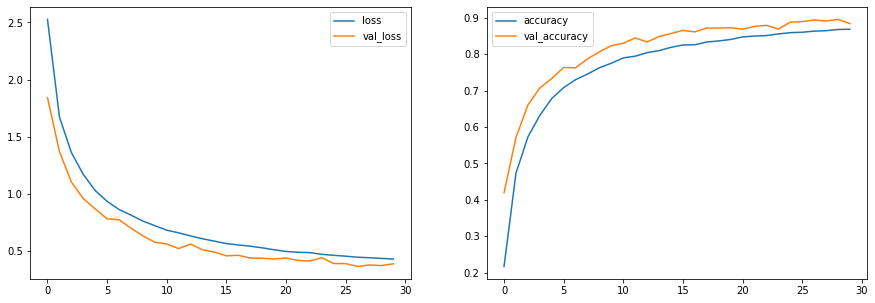

In [ ]:
evaluation(history3)

look, its way better now. no everfit here. but it think we can do more since our model not converge yet in this model

### 4th Model

on the previous model, we haven't messing around with the dense layer. so lets playing around with the dense layer by adding another layer and incerase the patience to 5 to watch our model progress farther.

In [ ]:
callbacks4 = [EarlyStopping(monitor = 'val_loss', patience = 5), 
    ModelCheckpoint('model4.hdf5', monitor='val_loss', save_best_only=True) # saving the best model
    #ReduceLROnPlateau
]

model4= Sequential()

model4.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= inputs))
model4.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= inputs))
model4.add(MaxPooling2D(pool_size=2, strides=2))

model4.add(Conv2D(filters=32, kernel_size=3, activation= 'relu', input_shape= inputs))
model4.add(Conv2D(filters=32, kernel_size=3, activation= 'relu', input_shape= inputs))
model4.add(MaxPooling2D(pool_size=2, strides=2))
model4.add(Dropout(0.2))

model4.add(Conv2D(filters=64, kernel_size=3, activation= 'relu', input_shape= inputs))
model4.add(Conv2D(filters=64, kernel_size=3, activation= 'relu', input_shape= inputs))
model4.add(MaxPooling2D(pool_size=2, strides=2))
model4.add(Dropout(0.2))

model4.add(Flatten())
model4.add(Dense(units=512, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(units=64, activation='relu'))
model4.add(Dropout(0.1))
model4.add(Dense(units=20, activation='softmax'))

model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
history4 = model4.fit(train_data, 
                   batch_size = BATCH,
                   epochs=100, 
                   validation_data=val_data,
                   callbacks=callbacks4)

Epoch 1/100
469/469 [==============================] - 47s 98ms/step - loss: 2.4188 - accuracy: 0.2284 - val_loss: 1.6909 - val_accuracy: 0.4425
Epoch 2/100
469/469 [==============================] - 46s 97ms/step - loss: 1.4838 - accuracy: 0.5184 - val_loss: 1.1403 - val_accuracy: 0.6393
Epoch 3/100
469/469 [==============================] - 46s 98ms/step - loss: 1.1070 - accuracy: 0.6460 - val_loss: 0.8500 - val_accuracy: 0.7345
Epoch 4/100
469/469 [==============================] - 45s 97ms/step - loss: 0.9144 - accuracy: 0.7123 - val_loss: 0.7353 - val_accuracy: 0.7752
Epoch 5/100
469/469 [==============================] - 45s 97ms/step - loss: 0.7852 - accuracy: 0.7541 - val_loss: 0.5833 - val_accuracy: 0.8208
Epoch 6/100
469/469 [==============================] - 45s 97ms/step - loss: 0.6969 - accuracy: 0.7852 - val_loss: 0.5724 - val_accuracy: 0.8219
Epoch 7/100
469/469 [==============================] - 46s 97ms/step - loss: 0.6500 - accuracy: 0.7995 - val_loss: 0.5101 - val_ac

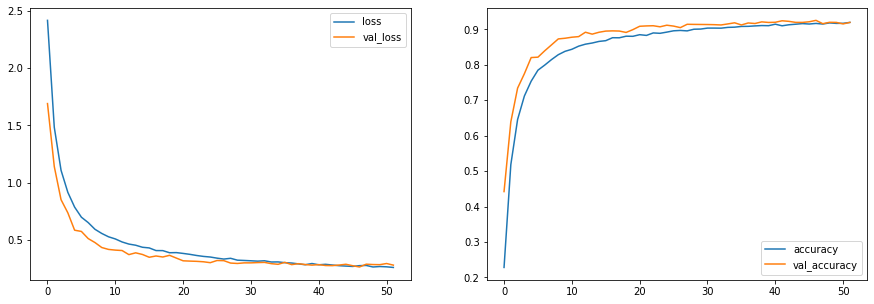

In [ ]:
evaluation(history4)

this is definetly way better than our last best model. our model now is perfectly fit and the accuracy is good as well. lets stick with this model and lets do further evaluation on model evaluation

## 8. Model Evaluation

In [ ]:
model4.evaluate(train_data)

469/469 [==============================] - 43s 91ms/step - loss: 0.1261 - accuracy: 0.9613


[0.1260630488395691, 0.9613000154495239]

In [ ]:
model4.evaluate(val_data)

157/157 [==============================] - 4s 27ms/step - loss: 0.2615 - accuracy: 0.9258


[0.26149696111679077, 0.9258000254631042]

In [ ]:
val_data.class_indices

{'10247': 0,
 '11090': 1,
 '11211': 2,
 '11212': 3,
 '11214': 4,
 '11458': 5,
 '11476': 6,
 '11477': 7,
 '14704': 8,
 '14719': 9,
 '14769': 10,
 '15068': 11,
 '15070': 12,
 '15100': 13,
 '15379': 14,
 '15392': 15,
 '15535': 16,
 '15573': 17,
 '15712': 18,
 '18651': 19}

In [ ]:
Y_pred_val = model4.predict(val_data)
y_pred_val = np.argmax(Y_pred_val, axis=1)

In [ ]:
print(classification_report(val_data.classes, y_pred_val))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       514
           1       0.92      0.94      0.93       493
           2       0.89      0.90      0.90       470
           3       1.00      0.99      0.99       495
           4       0.97      0.96      0.96       528
           5       0.90      0.90      0.90       515
           6       0.95      0.93      0.94       484
           7       0.85      0.81      0.83       490
           8       0.91      0.90      0.91       478
           9       0.96      0.98      0.97       485
          10       0.98      0.94      0.96       479
          11       0.96      0.93      0.95       510
          12       0.80      0.81      0.80       549
          13       0.90      0.92      0.91       495
          14       0.97      0.99      0.98       517
          15       0.92      0.95      0.93       491
          16       0.99      0.94      0.96       498
          17       0.96    

lets take a look on classification report above and lets evaluate interesting things that we can find there.

* class 3 so far has the best f1 score with score value 0.99. its mean that this class is the easiest class to predict by model with wrong prediction chance by 1%. lets have a look what kind lego class it is by showing the image, 

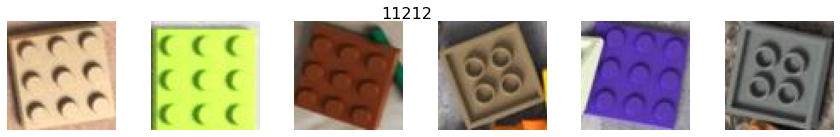

In [ ]:
#class 3 with best f1 score
im_plot(['11212'], 6)

* Mostly our model can predict each class with f1 score up to 0.9. but some class like 7, 12, 18 have f1 score less than that. by showing the image we might know why this class harder to predict than the most of class.

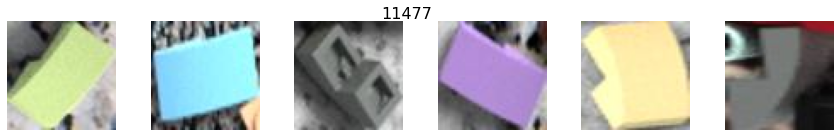

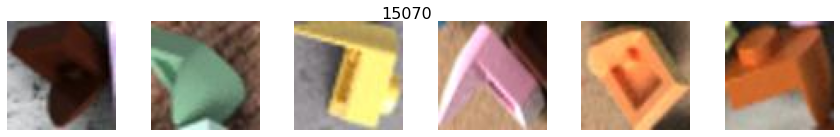

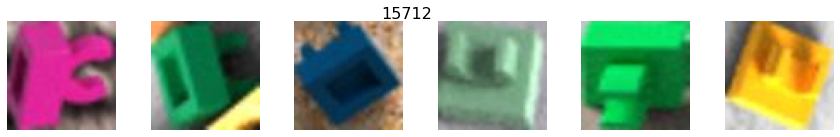

In [ ]:
# lego part with f1 score less than 90
im_plot(['11477', '15070', '15712'], 6)

* three lego part above are the hardest part to predict by the model, i have some asumption why this is can happen. the main reason why is because the shape of this lego part are too incosistent. lets take a look on model 15070. by changing camera and lego position its obviously will make the lego shape change extremely and lead to wrongly predicted to other lego parts. imagine you have this lego 15070 upside-down and this lego 15712 upside-down too, it turned out they both look really alike and this model definetly going to make wrong prediction.

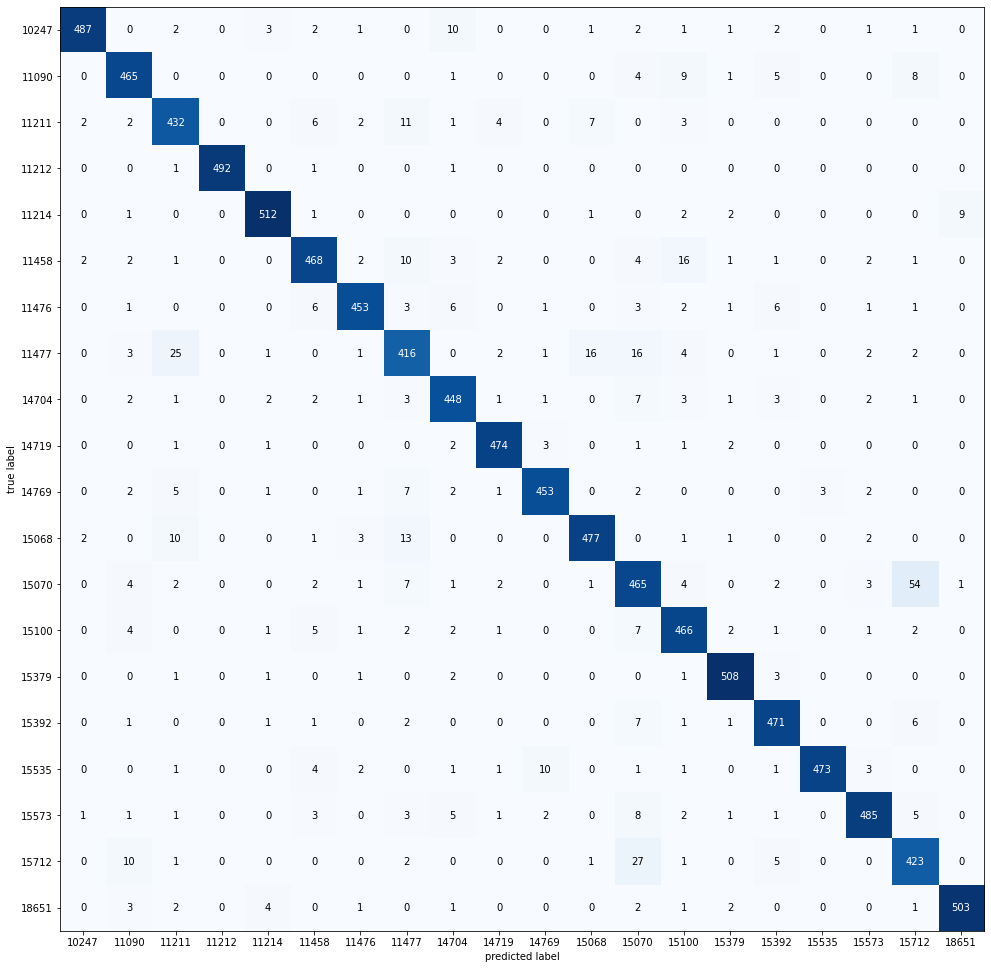

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
mat = confusion_matrix(val_data.classes, y_pred_val)

fig, ax = plot_confusion_matrix(conf_mat=mat,
                                colorbar=False,
                                show_absolute=True,
                                show_normed=False, figsize=(17,17))
plt.xticks(np.arange(20), target)
plt.yticks(np.arange(20), target)
plt.show()

## 9. Model Saving

In [ ]:
save_model(model4, 'best_model.h5')

## 10. Model Inference

for the inference, i search google and pick 5 images for each lego part.

folder link for inference images : https://drive.google.com/drive/folders/1QVbQudco9vnOmjunTUoGlwBjMDmTQuQE?usp=sharing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
target_inf = sorted(os.listdir('/content/drive/MyDrive/inference_ml2'))
target_inf.remove('model_best_bener.hdf5')

In [ ]:
main_path_inf = ['/content/drive/MyDrive/inference_ml2/']

In [ ]:
data = []
label = []
for i in target_inf:
  for j in range(5):
    a = main_path_inf[0] + i + '/' + os.listdir(main_path_inf[0]+i)[j]
    b = i
    data.append(a)
    label.append(b)

In [ ]:
df_inf = pd.DataFrame({'image': data, 'label': label}).sample(frac=1, random_state=0).reset_index(drop=True)

In [ ]:
df_inf.head()

image  label
0  /content/drive/MyDrive/inference_ml2/11458/4.jpg  11458
1  /content/drive/MyDrive/inference_ml2/15573/3.jpg  15573
2  /content/drive/MyDrive/inference_ml2/10247/3.jpg  10247
3  /content/drive/MyDrive/inference_ml2/15068/1.jpg  15068
4  /content/drive/MyDrive/inference_ml2/15392/2.jpg  15392

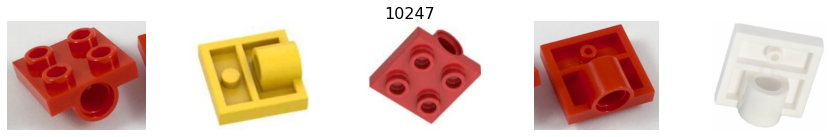

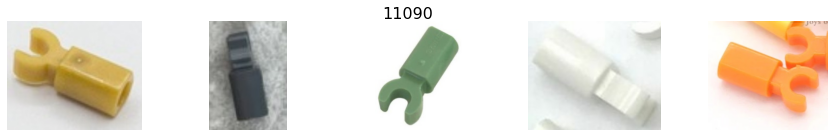

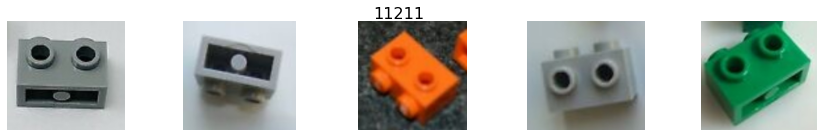

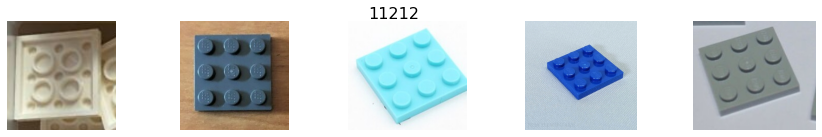

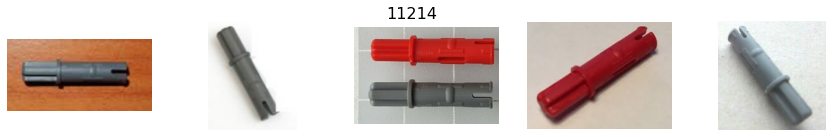

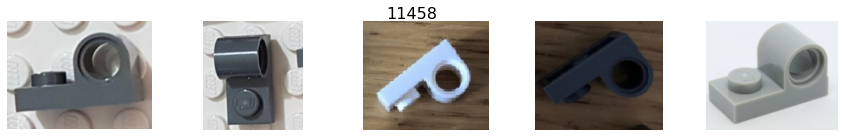

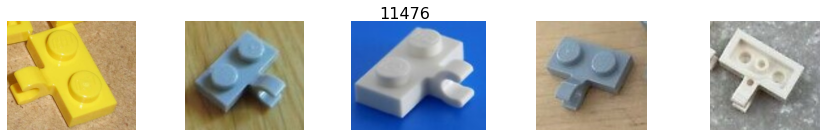

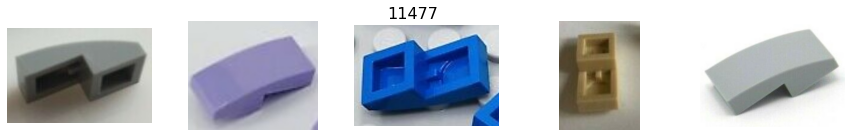

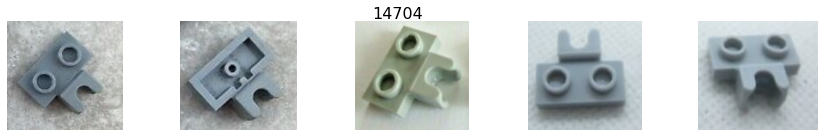

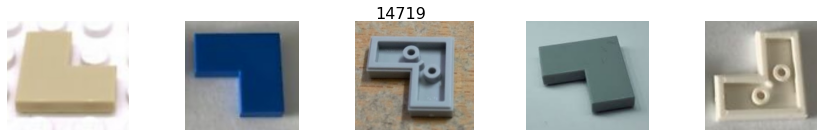

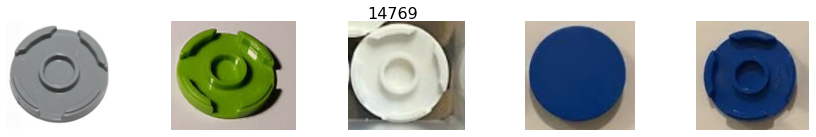

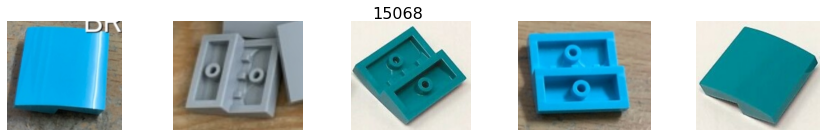

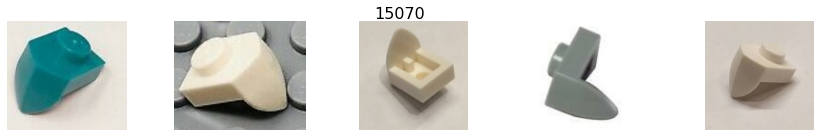

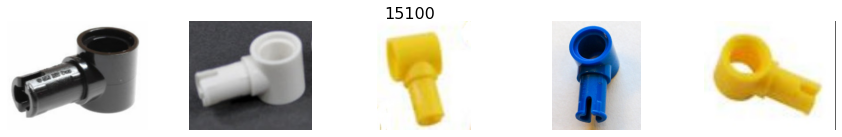

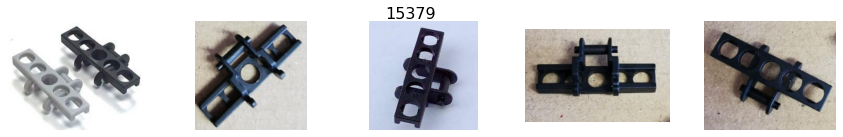

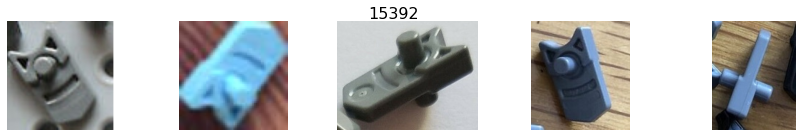

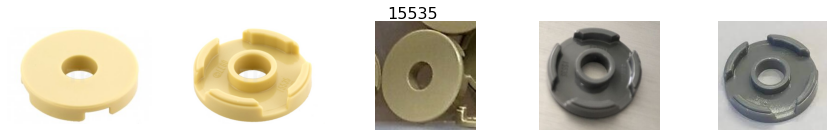

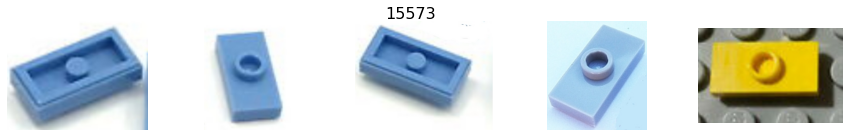

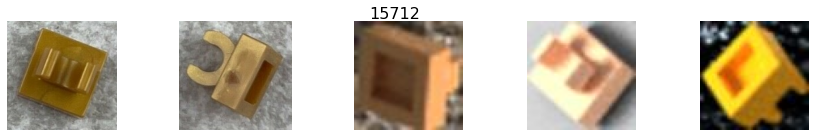

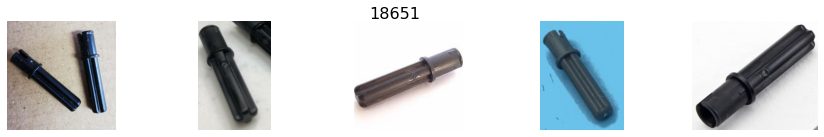

In [ ]:
im_plot(df_inf, target_inf, 5)

some part are rarely pop out on search, so i crop manually most of them and thats why some of picture are in hd and some are blured

In [ ]:
predicted = []
for i in df_inf['image']:
  img = cv2.imread(i)
  img = cv2.resize(img, (64, 64))
  img = img*1./255
  img2 = tf.expand_dims(img, axis=0)
  y_preds = model4.predict(img2)
  y_preds = np.argmax(y_preds)
  predicted.append(y_preds)

In [ ]:
dict = {0:'10247', 1:'11090', 2:'11211', 3:'11212', 4:'11214', 5:'11458', 
        6:'11476', 7:'11477', 8:'14704', 9:'14719', 10:'14769', 11:'15068',
        12:'15070', 13:'15100', 14:'15379', 15:'15392', 16:'15535', 17:'15573',
        18:'15712', 19:'18651'}

In [ ]:
df_inf['predicted'] = predicted
df_inf['predicted'] = df_inf['predicted'].map(dict)
df_inf['status'] = np.where(df_inf['label']==df_inf['predicted'],'CORRECT', 'INCORRECT')

In [ ]:
df_inf.head()

image  label predicted  \
0  /content/drive/MyDrive/inference_ml2/11458/4.jpg  11458     15379   
1  /content/drive/MyDrive/inference_ml2/15573/3.jpg  15573     15573   
2  /content/drive/MyDrive/inference_ml2/10247/3.jpg  10247     10247   
3  /content/drive/MyDrive/inference_ml2/15068/1.jpg  15068     15068   
4  /content/drive/MyDrive/inference_ml2/15392/2.jpg  15392     15392   

      status  
0  INCORRECT  
1    CORRECT  
2    CORRECT  
3    CORRECT  
4    CORRECT

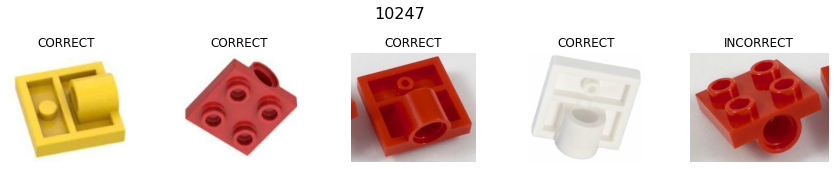

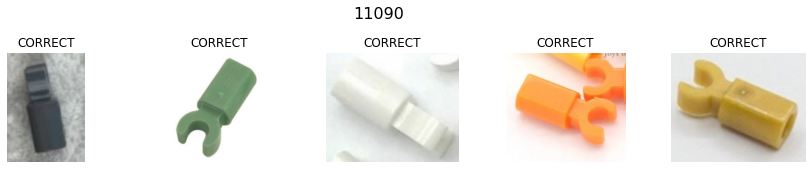

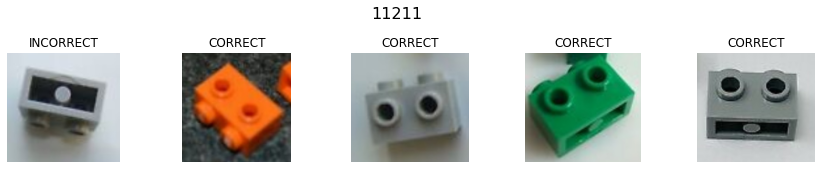

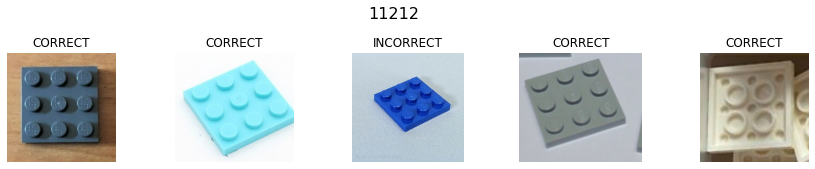

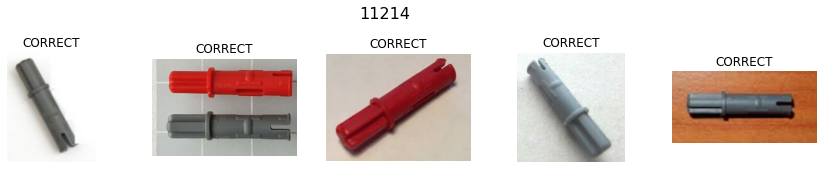

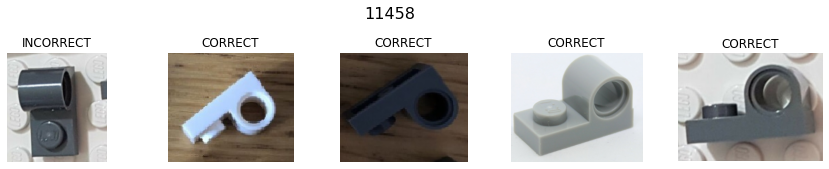

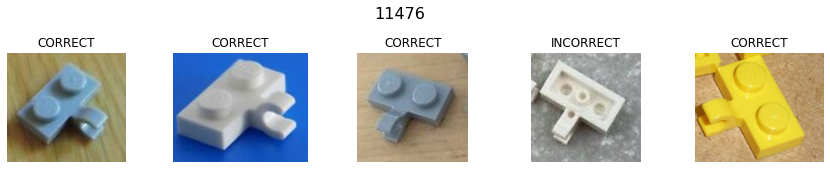

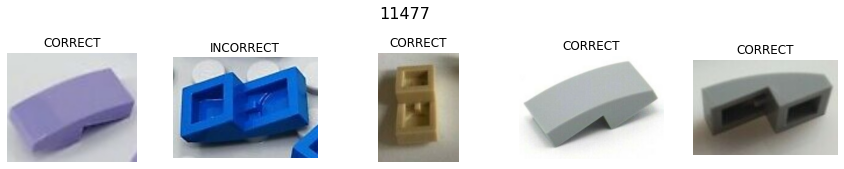

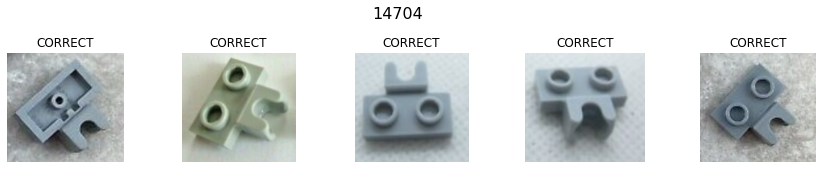

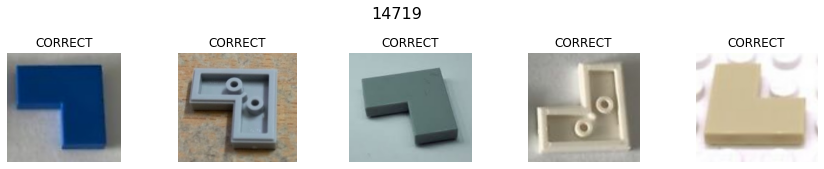

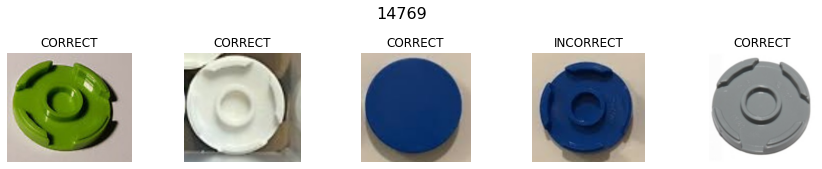

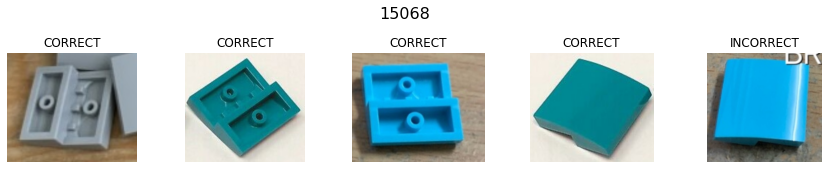

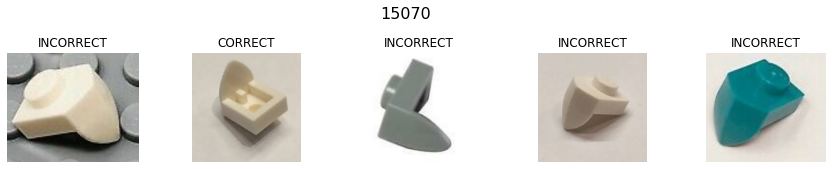

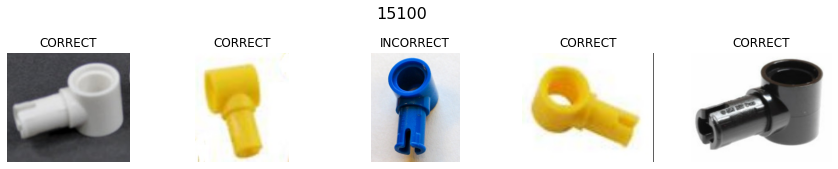

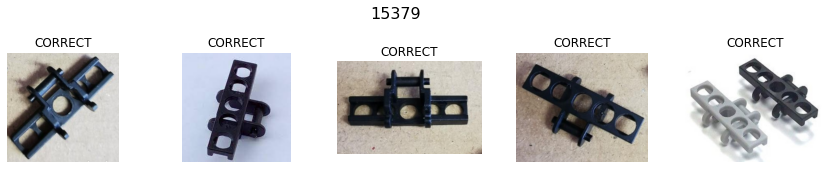

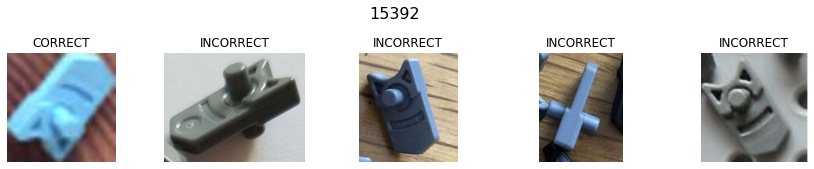

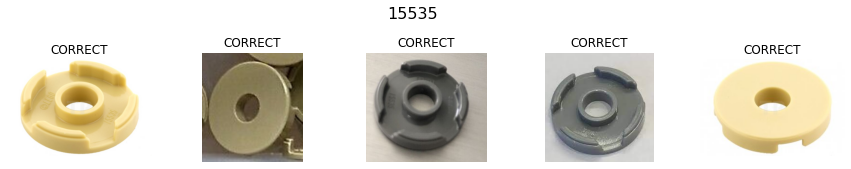

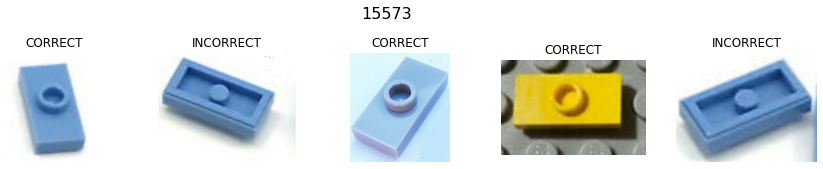

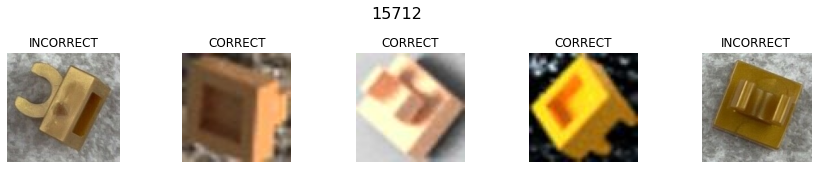

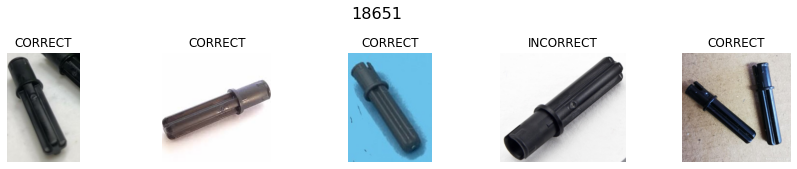

In [ ]:
for i in target_inf:
  a = df_inf[df_inf['label']==i]
  fig, ax = plt.subplots(1,5, figsize=(15,2))
  fig.suptitle(i, size=16, y=1.2)
  for j in range(5):
    img = cv2.imread(a['image'].iloc[j])
    ax[j].set_title(a['status'].iloc[j])
    ax[j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[j].axis('off')

In [ ]:
print(classification_report(df_inf['label'], df_inf['predicted']))

              precision    recall  f1-score   support

       10247       0.80      0.80      0.80         5
       11090       1.00      1.00      1.00         5
       11211       0.67      0.80      0.73         5
       11212       1.00      0.80      0.89         5
       11214       0.83      1.00      0.91         5
       11458       0.57      0.80      0.67         5
       11476       0.80      0.80      0.80         5
       11477       1.00      0.80      0.89         5
       14704       1.00      1.00      1.00         5
       14719       0.56      1.00      0.71         5
       14769       0.80      0.80      0.80         5
       15068       0.80      0.80      0.80         5
       15070       1.00      0.20      0.33         5
       15100       1.00      0.80      0.89         5
       15379       0.42      1.00      0.59         5
       15392       1.00      0.20      0.33         5
       15535       0.83      1.00      0.91         5
       15573       1.00    

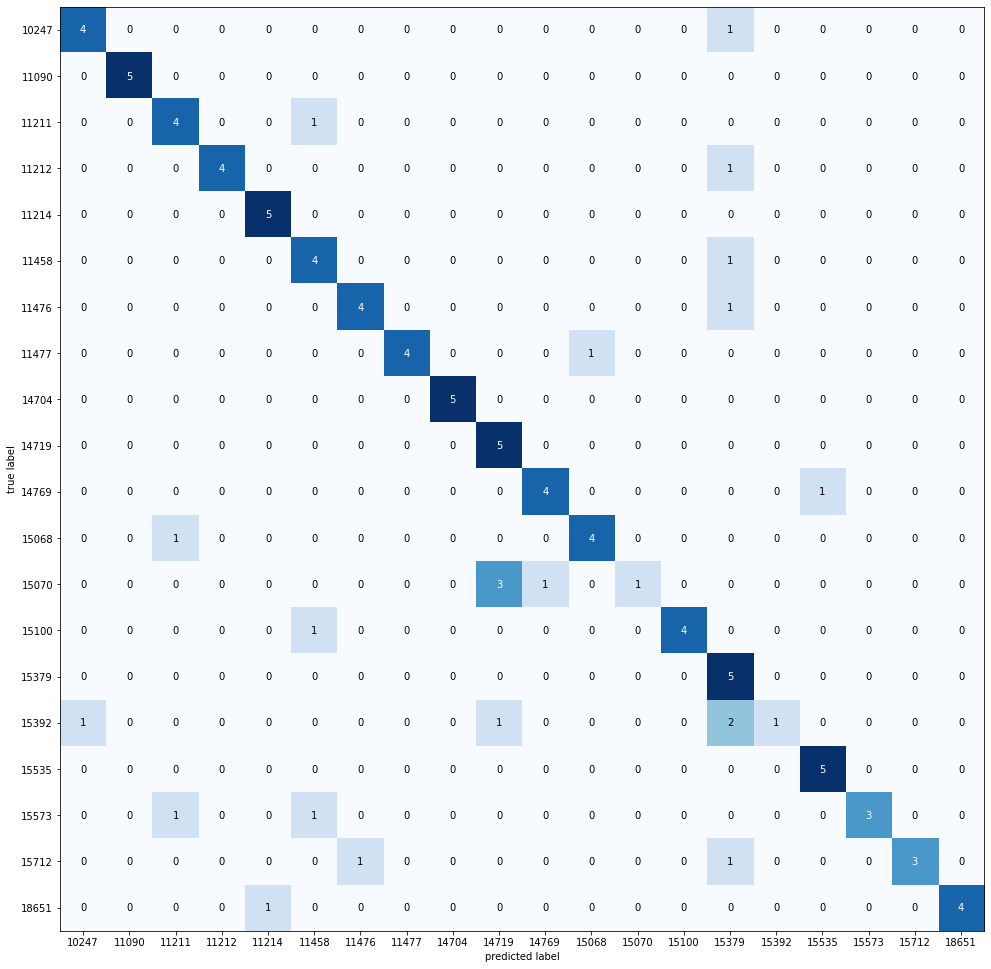

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
mat = confusion_matrix(df_inf['label'], df_inf['predicted'])

fig, ax = plot_confusion_matrix(conf_mat=mat,
                                colorbar=False,
                                show_absolute=True,
                                show_normed=False, figsize=(17,17))
plt.xticks(np.arange(20), target_inf)
plt.yticks(np.arange(20), target_inf)
plt.show()

from the prediction of inference data we can conclude that,
1. model capable to predict  nearly most of the class
2. but at some class(15392 and 15070), model is totaly fail to predict the inference. 
3. lego 15379 have really low precision but high recall, its mean that many of other class miss-predict as class 15379
4. lego 14719 have really low precision but high recall, its mean that many of other class miss-predict as class 14719
4. lego 15070 miss predict 3 times as 14719

## 11. Conclusion

some conclusion that you might find helpful

1. in this project, the best model is capable to achieve accuracy up to 90% both on train and validation
2. best NN architecture that can achieve highest accuracy in this project is consist of 3 kind of different doubled filters and 2 dense layer with 512 & 64 neurons
3. using inference data, model is capable to predict  nearly most of the class but at some class(15392 and 15070), model is totaly fail to predict the inference.